Connected to Python 3.8.10

In [1]:
from amuse.lab import nbody_system

from amuse.ext.molecular_cloud import molecular_cloud
from amuse.ext.evrard_test import body_centered_grid_unit_cube

from amuse.community.fi.interface import Fi

from amuse.units import units
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# plot molecular cloud density function (smooth)
def make_map(hydro, L, N):
    '''
    Description:

    Inputs:
        hydro (object): AMUSE Fi hydrodynamic integrator
        L (int): Axis length 
        N (int): Number of grid points

    Return: 
        rho ()
    '''

    x = np.linspace(-L, L, N + 1)
    y = np.linspace(-L, L, N + 1)
    xv, yv = np.meshgrid(x, y)

    x = xv.flatten() | units.pc
    y = yv.flatten() | units.pc
    z = 0 | units.pc
    vx = 0 | units.kms
    vy = 0 | units.kms
    vz = 0 | units.kms

    rho = hydro.get_hydro_state_at_point(x, y, z, vx, vy, vz)[0]
    rho = rho.reshape((N + 1, N + 1))
    
    return rho
    
def plot_hydro(time, hydro, L, N):

    fig = plt.figure(figsize = (9, 5))
    
    rho = make_map(hydro, L = L, N = N)
    cax = plt.imshow(np.log10(rho.value_in(units.amu/units.cm**3)), extent=[-L, L, -L, L], vmin = 0, vmax = 5)
    cbar = fig.colorbar(cax)
    cbar.set_label('log density [$amu/cm^3$]', labelpad = 5)
        
    plt.title("Molecular cloud at time = " + time.as_string_in(units.Myr))
    plt.xlabel("x [pc]")
    plt.ylabel("y [pc]")
    plt.show()

In [3]:
def make_molecular_cloud(N_cloud, M_cloud, R_cloud, seed):
    '''
    Description:
        Generating a molecular cloud
        
    Inputs:
        N_cloud (Int): Number of particles in the molecular cloud
        
        M_cloud (units.quantity): Total mass of the cloud
        
        R_cloud (units.quantity): Radius of the cloud
        
        seed (int): Randomness of the function
    
    Returns:
        particles_cloud (object): AMUSE particle set for the molecular cloud
        converter_cloud (object): AMUSE generic unit converter for the cloud 
    '''

    converter_cloud = nbody_system.nbody_to_si(M_cloud, R_cloud)

    # creates a smooth spherical cloud with random velocities as in Bonnell et al. (2003)
    particles_cloud = molecular_cloud(targetN = N_cloud, 
                                    convert_nbody = converter_cloud,
                                    base_grid = body_centered_grid_unit_cube,
                                    seed = seed).result 
    
    return particles_cloud, converter_cloud

In [4]:
def evolve_molecular_cloud(particles_cloud, converter_cloud, t_end, dt, resolution, seed):
    '''
    Description:
        Evolve a existing molecular cloud to a certain age

    Inputs:
        particles_cloud (object): AMUSE particle set for the molecular cloud 
        converter_cloud (object): AMUSE generic unit converter
        t_end (units.quantity): Total length of the evolution
        dt (units.quantity): Time step of the evolution
        resolution (units.quantity): Gas particle smoothing length 
        seed (int): Randomness of the function 

    Return:
        particles_cloud (object): AMUSE particle set for the evolved molecular cloud

    '''

    np.random.seed(seed)

    hydro_cloud = Fi(converter_cloud)

    hydro_cloud.parameters.use_hydro_flag = True # Hydrodynamics flag. True means: SPH hydro included, False means: gravity only.
    hydro_cloud.parameters.radiation_flag = False # Radiation flag. True means: radiation (i.e. radiative cooling/heating) is included. False means: no radiation, and implies no star formation. (default value:False)

    hydro_cloud.parameters.gamma = 1 # gas polytropic index (1.6666667) (default value:1.6666667)
    hydro_cloud.parameters.isothermal_flag = True # Isothermal flag. True means: isothermal gas (requires integrate_entropy_flag == False). (default value:False)
    hydro_cloud.parameters.integrate_entropy_flag = False # Integrate-entropy flag. True means: integrate entropy, else: internal energy. (default value:True)
    hydro_cloud.parameters.timestep = dt # timestep for system (default value:4.70451599238e+13 s)

    hydro_cloud.parameters.eps_is_h_flag = False  #Eps-is-h flag. True means: set gas particles gravitational epsilon to h (SPH smoothing length). (default value:True)
                                                # h_smooth is constant
    hydro_cloud.parameters.gas_epsilon = resolution # The gas gravitational smoothing epsilon.
    hydro_cloud.parameters.sph_h_const = resolution # SPH smoothing length if constant
    particles_cloud.h_smooth= resolution

    hydro_cloud.gas_particles.add_particles(particles_cloud)

    channel = {"hydro_to_part": hydro_cloud.gas_particles.new_channel_to(particles_cloud),
            "part_to_hydro": particles_cloud.new_channel_to(hydro_cloud.gas_particles)}

    L = int(max(particles_cloud.x.value_in(units.pc)))*1.5  # x and y lim of plot. 
    N = 1000 # amount of grid points

    model_time = 0 | units.Myr

    plot_hydro(model_time, hydro_cloud, L, N)
    print("ready for evolution")

    while model_time < t_end:

        model_time += dt
        model_time = model_time.round(1)

        hydro_cloud.evolve_model(model_time)
        print("Time", model_time.in_(units.Myr))
        channel["hydro_to_part"].copy()

    plot_hydro(model_time, hydro_cloud, L, N)
    plot_hydro(model_time, hydro_cloud, 25, N)

    hydro_cloud.stop()

    return particles_cloud

In [5]:
particles_cloud, converter_cloud  = make_molecular_cloud(N_cloud = 50_000,
                                                         M_cloud = 1_000 | units.MSun,
                                                         R_cloud = 20 | units.parsec,
                                                         seed = 1312)

print(f"Average mass of a SPH particle {particles_cloud.mass.sum().value_in(units.MSun)/len(particles_cloud.mass)}.")
print(f"Average radius of a SPH particle {particles_cloud.radius.sum().value_in(units.RSun)/len(particles_cloud.mass)}.")

particles_cloud = evolve_molecular_cloud(particles_cloud, 
                                         converter_cloud, 
                                         2 | units.Myr, 
                                         0.2 | units.Myr, 
                                         1 | units.RSun,
                                         1312)

print(f"Average mass of a SPH particle {particles_cloud.mass.sum().value_in(units.MSun)/len(particles_cloud.mass)}.")
print(f"Average radius of a SPH particle {particles_cloud.radius.sum().value_in(units.RSun)/len(particles_cloud.mass)}.")

# particles_cloud, converter_cloud = make_molecular_cloud(100_000, 10_000_000 | units.MSun, 200 | units.parsec, 1312)
# particles_cloud = evolve_molecular_cloud(particles_cloud, converter_cloud, 2 | units.Myr, 0.2 | units.Myr, 1 | units.RSun, 1312)

Average mass of a SPH particle 0.020494743098395246.


AttributeError: You tried to access attribute 'radius' but this attribute is not defined for this set.

In [6]:
dir(particles_cloud)

['GLOBAL_DERIVED_ATTRIBUTES',
 'LagrangianRadii',
 'Qparameter',
 '__add__',
 '__array__',
 '__array_interface__',
 '__array_struct__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__or__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__weakref__',
 '_add_indices_in_attribute_storage',
 '_as_masked_subset_in',
 '_attributes_for_dir',
 '_convert_from_entities_or_quantities',
 '_convert_to_entities_or_quantities',
 '_convert_to_entities_or_quantities_async',
 '_convert_to_entity_or_quantity',
 '_factory_for_new_collection',
 '_get_derived_attribute_value',
 '_get_particle',
 '_get_particle_unsave',
 '_get_value_of_attribute',
 '_get_values_

Average mass of a SPH particle 0.020494743098395246.


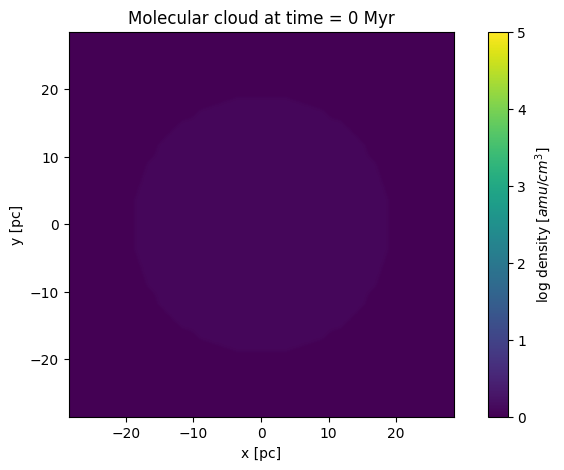

ready for evolution
Time 0.2 Myr
Time 0.4 Myr
Time 0.6 Myr
Time 0.8 Myr
Time 1.0 Myr
Time 1.2 Myr
Time 1.4 Myr
Time 1.6 Myr
Time 1.8 Myr
Time 2.0 Myr


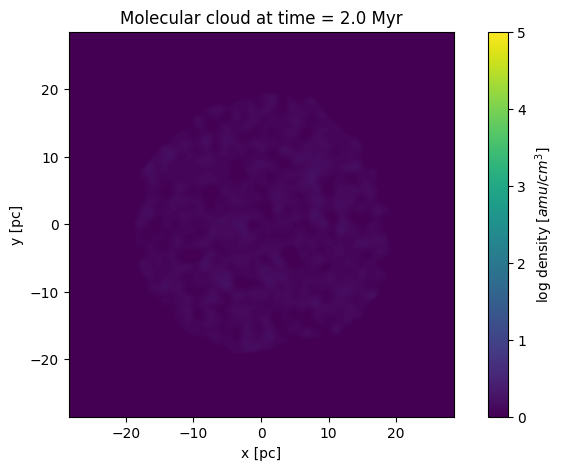

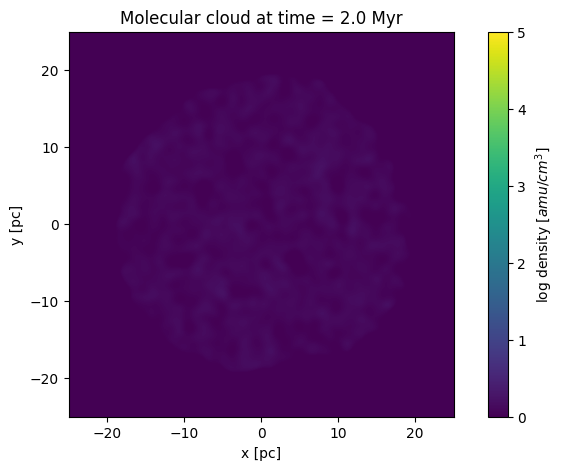

Average mass of a SPH particle 0.020494743098395246.
Average radius of a SPH particle 1.0.


In [7]:
particles_cloud, converter_cloud  = make_molecular_cloud(N_cloud = 50_000,
                                                         M_cloud = 1_000 | units.MSun,
                                                         R_cloud = 20 | units.parsec,
                                                         seed = 1312)

print(f"Average mass of a SPH particle {particles_cloud.mass.sum().value_in(units.MSun)/len(particles_cloud.mass)}.")

particles_cloud = evolve_molecular_cloud(particles_cloud, 
                                         converter_cloud, 
                                         2 | units.Myr, 
                                         0.2 | units.Myr, 
                                         1 | units.RSun,
                                         1312)

print(f"Average mass of a SPH particle {particles_cloud.mass.sum().value_in(units.MSun)/len(particles_cloud.mass)}.")
print(f"Average radius of a SPH particle {particles_cloud.radius.sum().value_in(units.RSun)/len(particles_cloud.mass)}.")

# particles_cloud, converter_cloud = make_molecular_cloud(100_000, 10_000_000 | units.MSun, 200 | units.parsec, 1312)
# particles_cloud = evolve_molecular_cloud(particles_cloud, converter_cloud, 2 | units.Myr, 0.2 | units.Myr, 1 | units.RSun, 1312)

In [8]:
# plot molecular cloud density function (smooth)
def make_map(hydro, L, N):
    '''
    Description:

    Inputs:
        hydro (object): AMUSE Fi hydrodynamic integrator
        L (int): Axis length 
        N (int): Number of grid points

    Return: 
        rho ()
    '''

    x = np.linspace(-L, L, N + 1)
    y = np.linspace(-L, L, N + 1)
    xv, yv = np.meshgrid(x, y)

    x = xv.flatten() | units.pc
    y = yv.flatten() | units.pc
    z = 0 | units.pc
    vx = 0 | units.kms
    vy = 0 | units.kms
    vz = 0 | units.kms

    rho = hydro.get_hydro_state_at_point(x, y, z, vx, vy, vz)[0]
    rho = rho.reshape((N + 1, N + 1))
    
    return rho
    
def plot_hydro(time, hydro, L, N):

    fig = plt.figure(figsize = (9, 5))
    
    rho = make_map(hydro, L = L, N = N)
    cax = plt.imshow(np.log10(rho.value_in(units.amu/units.cm**3)), extent=[-L, L, -L, L], vmin = 0, vmax = 5)
    cbar = fig.colorbar(cax)
    cbar.set_label('log density [$amu/cm^3$]', labelpad = 5)
        
    plt.title("Molecular cloud at time = " + time.as_string_in(units.Myr))
    plt.xlabel("x [pc]")
    plt.ylabel("y [pc]")
    plt.show()

def plot_cloud_particles(time, particles_cloud):

    fig = plt.figure(figsize = (9, 5))
    
    plt.scatter(particles_cloud.x.values_in(units.pc), particles_cloud.y.values_in(units.pc))
    plt.title("Molecular cloud at time = " + time.as_string_in(units.Myr))
    plt.xlabel("x [pc]")
    plt.ylabel("y [pc]")
    plt.show()

In [9]:
def evolve_molecular_cloud(particles_cloud, converter_cloud, t_end, dt, resolution, seed):
    '''
    Description:
        Evolve a existing molecular cloud to a certain age

    Inputs:
        particles_cloud (object): AMUSE particle set for the molecular cloud 
        converter_cloud (object): AMUSE generic unit converter
        t_end (units.quantity): Total length of the evolution
        dt (units.quantity): Time step of the evolution
        resolution (units.quantity): Gas particle smoothing length 
        seed (int): Randomness of the function 

    Return:
        particles_cloud (object): AMUSE particle set for the evolved molecular cloud

    '''

    np.random.seed(seed)

    hydro_cloud = Fi(converter_cloud)

    hydro_cloud.parameters.use_hydro_flag = True # Hydrodynamics flag. True means: SPH hydro included, False means: gravity only.
    hydro_cloud.parameters.radiation_flag = False # Radiation flag. True means: radiation (i.e. radiative cooling/heating) is included. False means: no radiation, and implies no star formation. (default value:False)

    hydro_cloud.parameters.gamma = 1 # gas polytropic index (1.6666667) (default value:1.6666667)
    hydro_cloud.parameters.isothermal_flag = True # Isothermal flag. True means: isothermal gas (requires integrate_entropy_flag == False). (default value:False)
    hydro_cloud.parameters.integrate_entropy_flag = False # Integrate-entropy flag. True means: integrate entropy, else: internal energy. (default value:True)
    hydro_cloud.parameters.timestep = dt # timestep for system (default value:4.70451599238e+13 s)

    hydro_cloud.parameters.eps_is_h_flag = False  #Eps-is-h flag. True means: set gas particles gravitational epsilon to h (SPH smoothing length). (default value:True)
                                                # h_smooth is constant
    hydro_cloud.parameters.gas_epsilon = resolution # The gas gravitational smoothing epsilon.
    hydro_cloud.parameters.sph_h_const = resolution # SPH smoothing length if constant
    particles_cloud.h_smooth= resolution

    hydro_cloud.gas_particles.add_particles(particles_cloud)

    channel = {"hydro_to_part": hydro_cloud.gas_particles.new_channel_to(particles_cloud),
            "part_to_hydro": particles_cloud.new_channel_to(hydro_cloud.gas_particles)}

    L = int(max(particles_cloud.x.value_in(units.pc)))*1.5  # x and y lim of plot. 
    N = 1000 # amount of grid points

    model_time = 0 | units.Myr

    plot_hydro(model_time, hydro_cloud, L, N)
    plot_cloud_particles(model_time, particles_cloud)
    print("ready for evolution")

    while model_time < t_end:

        model_time += dt
        model_time = model_time.round(1)

        hydro_cloud.evolve_model(model_time)
        print("Time", model_time.in_(units.Myr))
        channel["hydro_to_part"].copy()

    plot_hydro(model_time, hydro_cloud, L, N)
    plot_hydro(model_time, hydro_cloud, 25, N)
    plot_cloud_particles(model_time, particles_cloud)

    hydro_cloud.stop()

    return particles_cloud

In [10]:
# plot molecular cloud density function (smooth)
def make_map(hydro, L, N):
    '''
    Description:

    Inputs:
        hydro (object): AMUSE Fi hydrodynamic integrator
        L (int): Axis length 
        N (int): Number of grid points

    Return: 
        rho ()
    '''

    x = np.linspace(-L, L, N + 1)
    y = np.linspace(-L, L, N + 1)
    xv, yv = np.meshgrid(x, y)

    x = xv.flatten() | units.pc
    y = yv.flatten() | units.pc
    z = 0 | units.pc
    vx = 0 | units.kms
    vy = 0 | units.kms
    vz = 0 | units.kms

    rho = hydro.get_hydro_state_at_point(x, y, z, vx, vy, vz)[0]
    rho = rho.reshape((N + 1, N + 1))
    
    return rho
    
def plot_hydro(time, hydro, L, N):

    fig = plt.figure(figsize = (9, 5))
    
    rho = make_map(hydro, L = L, N = N)
    cax = plt.imshow(np.log10(rho.value_in(units.amu/units.cm**3)), extent=[-L, L, -L, L]) #, vmin = 0, vmax = 5)
    cbar = fig.colorbar(cax)
    cbar.set_label('log density [$amu/cm^3$]', labelpad = 5)
        
    plt.title("Molecular cloud at time = " + time.as_string_in(units.Myr))
    plt.xlabel("x [pc]")
    plt.ylabel("y [pc]")
    plt.show()

def plot_cloud_particles(time, particles_cloud):

    fig = plt.figure(figsize = (9, 5))

    plt.scatter(particles_cloud.x.values_in(units.pc), particles_cloud.y.values_in(units.pc))
    plt.title("Molecular cloud at time = " + time.as_string_in(units.Myr))
    plt.xlabel("x [pc]")
    plt.ylabel("y [pc]")
    plt.show()

Average mass of a SPH particle 0.020494743098395246.


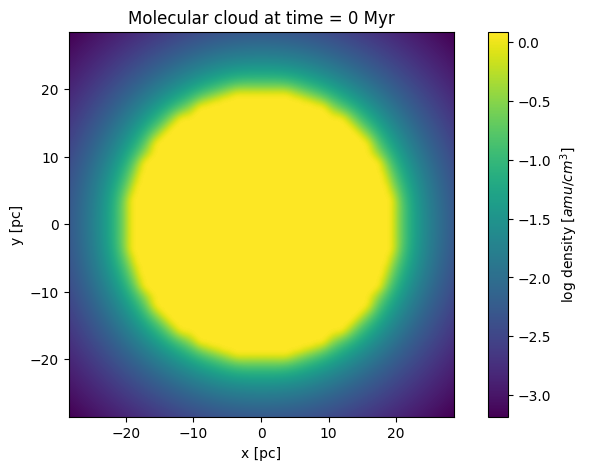

AttributeError: 'VectorQuantity' object has no attribute 'values_in'

<Figure size 900x500 with 0 Axes>

In [11]:
particles_cloud, converter_cloud  = make_molecular_cloud(N_cloud = 50_000,
                                                         M_cloud = 1_000 | units.MSun,
                                                         R_cloud = 20 | units.parsec,
                                                         seed = 1312)

print(f"Average mass of a SPH particle {particles_cloud.mass.sum().value_in(units.MSun)/len(particles_cloud.mass)}.")

particles_cloud = evolve_molecular_cloud(particles_cloud, 
                                         converter_cloud, 
                                         2 | units.Myr, 
                                         0.2 | units.Myr, 
                                         1 | units.RSun,
                                         1312)

print(f"Average mass of a SPH particle {particles_cloud.mass.sum().value_in(units.MSun)/len(particles_cloud.mass)}.")
print(f"Average radius of a SPH particle {particles_cloud.radius.sum().value_in(units.RSun)/len(particles_cloud.mass)}.")

# particles_cloud, converter_cloud = make_molecular_cloud(100_000, 10_000_000 | units.MSun, 200 | units.parsec, 1312)
# particles_cloud = evolve_molecular_cloud(particles_cloud, converter_cloud, 2 | units.Myr, 0.2 | units.Myr, 1 | units.RSun, 1312)

In [12]:
# plot molecular cloud density function (smooth)
def make_map(hydro, L, N):
    '''
    Description:

    Inputs:
        hydro (object): AMUSE Fi hydrodynamic integrator
        L (int): Axis length 
        N (int): Number of grid points

    Return: 
        rho ()
    '''

    x = np.linspace(-L, L, N + 1)
    y = np.linspace(-L, L, N + 1)
    xv, yv = np.meshgrid(x, y)

    x = xv.flatten() | units.pc
    y = yv.flatten() | units.pc
    z = 0 | units.pc
    vx = 0 | units.kms
    vy = 0 | units.kms
    vz = 0 | units.kms

    rho = hydro.get_hydro_state_at_point(x, y, z, vx, vy, vz)[0]
    rho = rho.reshape((N + 1, N + 1))
    
    return rho
    
def plot_hydro(time, hydro, L, N):

    fig = plt.figure(figsize = (9, 5))
    
    rho = make_map(hydro, L = L, N = N)
    cax = plt.imshow(np.log10(rho.value_in(units.amu/units.cm**3)), extent=[-L, L, -L, L]) #, vmin = 0, vmax = 5)
    cbar = fig.colorbar(cax)
    cbar.set_label('log density [$amu/cm^3$]', labelpad = 5)
        
    plt.title("Molecular cloud at time = " + time.as_string_in(units.Myr))
    plt.xlabel("x [pc]")
    plt.ylabel("y [pc]")
    plt.show()

def plot_cloud_particles(time, particles_cloud):

    fig = plt.figure(figsize = (9, 5))

    plt.scatter(particles_cloud.x.value_in(units.pc), particles_cloud.y.value_in(units.pc))
    plt.title("Molecular cloud at time = " + time.as_string_in(units.Myr))
    plt.xlabel("x [pc]")
    plt.ylabel("y [pc]")
    plt.show()

Average mass of a SPH particle 0.020494743098395246.


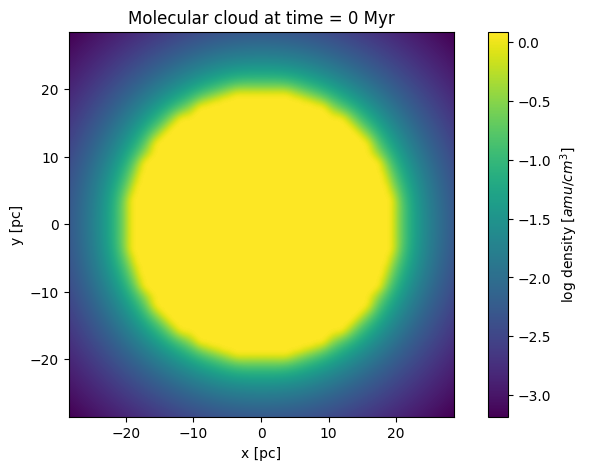

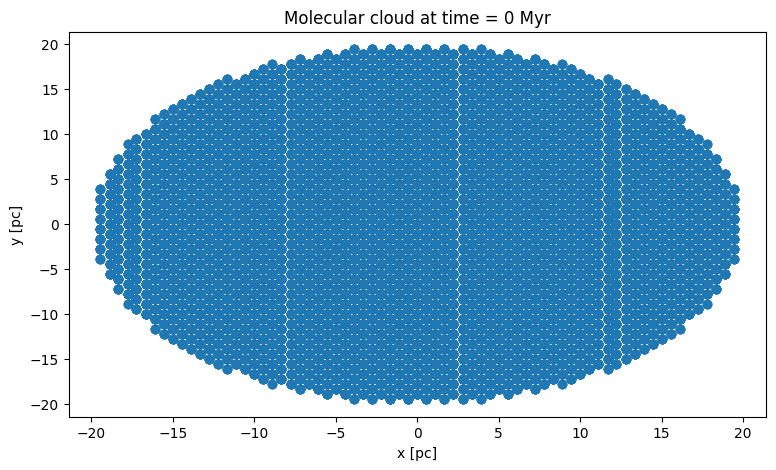

ready for evolution
Time 0.2 Myr
Time 0.4 Myr
Time 0.6 Myr
Time 0.8 Myr
Time 1.0 Myr
Time 1.2 Myr
Time 1.4 Myr
Time 1.6 Myr
Time 1.8 Myr
Time 2.0 Myr


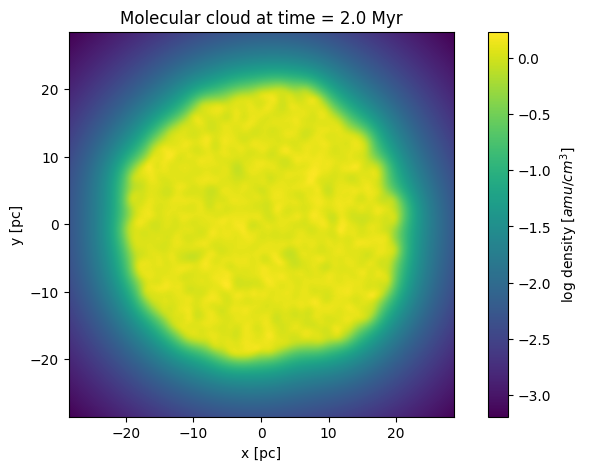

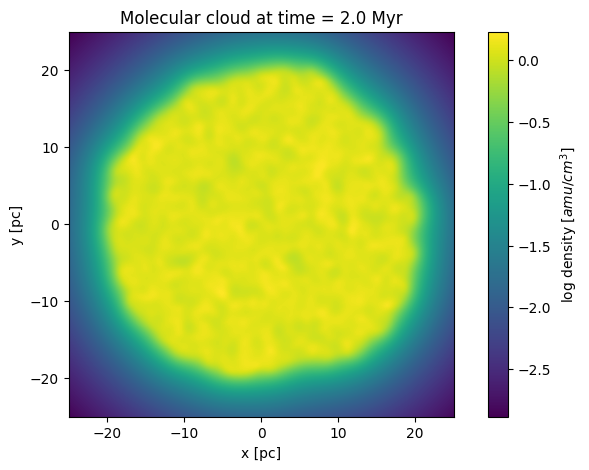

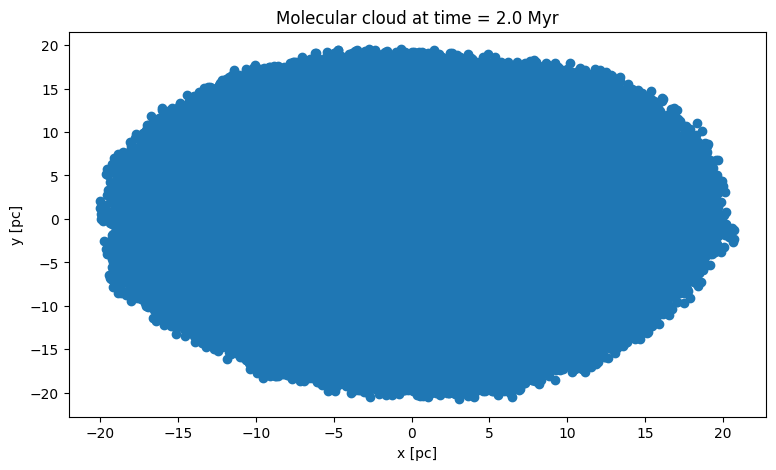

Average mass of a SPH particle 0.020494743098395246.
Average radius of a SPH particle 1.0.


In [13]:
particles_cloud, converter_cloud  = make_molecular_cloud(N_cloud = 50_000,
                                                         M_cloud = 1_000 | units.MSun,
                                                         R_cloud = 20 | units.parsec,
                                                         seed = 1312)

print(f"Average mass of a SPH particle {particles_cloud.mass.sum().value_in(units.MSun)/len(particles_cloud.mass)}.")

particles_cloud = evolve_molecular_cloud(particles_cloud, 
                                         converter_cloud, 
                                         2 | units.Myr, 
                                         0.2 | units.Myr, 
                                         1 | units.RSun,
                                         1312)

print(f"Average mass of a SPH particle {particles_cloud.mass.sum().value_in(units.MSun)/len(particles_cloud.mass)}.")
print(f"Average radius of a SPH particle {particles_cloud.radius.sum().value_in(units.RSun)/len(particles_cloud.mass)}.")

# particles_cloud, converter_cloud = make_molecular_cloud(100_000, 10_000_000 | units.MSun, 200 | units.parsec, 1312)
# particles_cloud = evolve_molecular_cloud(particles_cloud, converter_cloud, 2 | units.Myr, 0.2 | units.Myr, 1 | units.RSun, 1312)

In [14]:
# plot molecular cloud density function (smooth)
def make_map(hydro, L, N):
    '''
    Description:

    Inputs:
        hydro (object): AMUSE Fi hydrodynamic integrator
        L (int): Axis length 
        N (int): Number of grid points

    Return: 
        rho ()
    '''

    x = np.linspace(-L, L, N + 1)
    y = np.linspace(-L, L, N + 1)
    xv, yv = np.meshgrid(x, y)

    x = xv.flatten() | units.pc
    y = yv.flatten() | units.pc
    z = 0 | units.pc
    vx = 0 | units.kms
    vy = 0 | units.kms
    vz = 0 | units.kms

    rho = hydro.get_hydro_state_at_point(x, y, z, vx, vy, vz)[0]
    rho = rho.reshape((N + 1, N + 1))
    
    return rho
    
def plot_hydro(time, hydro, L, N):

    fig = plt.figure(figsize = (9, 5))
    
    rho = make_map(hydro, L = L, N = N)
    cax = plt.imshow(np.log10(rho.value_in(units.amu/units.cm**3)), extent=[-L, L, -L, L]) #, vmin = 0, vmax = 5)
    cbar = fig.colorbar(cax)
    cbar.set_label('log density [$amu/cm^3$]', labelpad = 5)
        
    plt.title("Molecular cloud at time = " + time.as_string_in(units.Myr))
    plt.xlabel("x [pc]")
    plt.ylabel("y [pc]")
    plt.show()

def plot_cloud_particles(time, particles_cloud):

    fig = plt.figure(figsize = (9, 5))

    plt.scatter(particles_cloud.x.value_in(units.pc), particles_cloud.y.value_in(units.pc), s = 1)
    plt.title("Molecular cloud at time = " + time.as_string_in(units.Myr))
    plt.xlabel("x [pc]")
    plt.ylabel("y [pc]")
    plt.show()

Average mass of a SPH particle 1.8832391713747643.


<ipython-input-14-c60224121ede>:38: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  cax = plt.imshow(np.log10(rho.value_in(units.amu/units.cm**3)), extent=[-L, L, -L, L]) #, vmin = 0, vmax = 5)
<ipython-input-14-c60224121ede>:38: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  cax = plt.imshow(np.log10(rho.value_in(units.amu/units.cm**3)), extent=[-L, L, -L, L]) #, vmin = 0, vmax = 5)


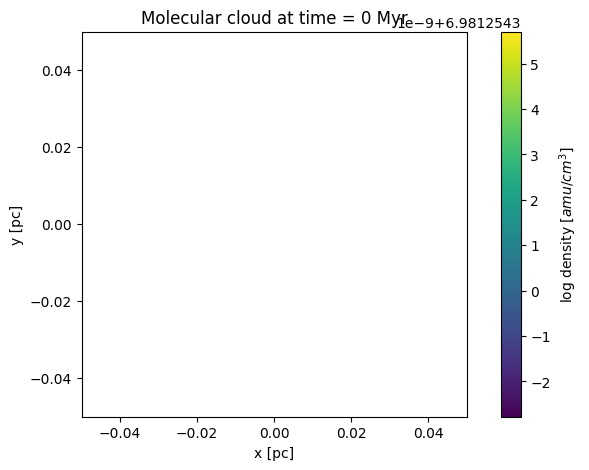

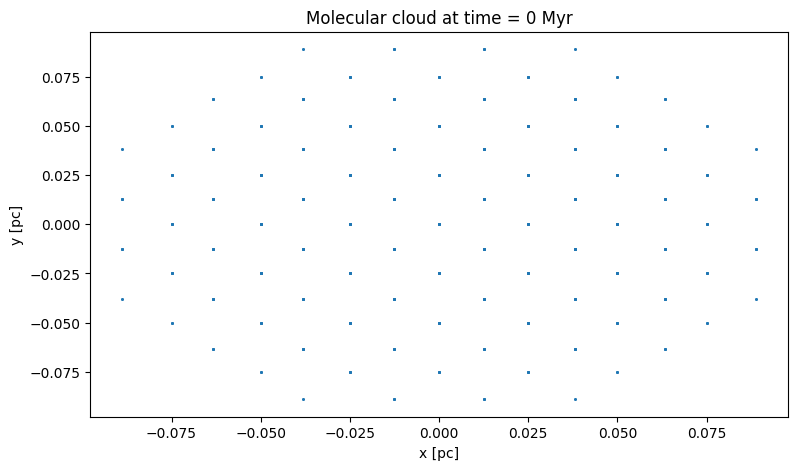

ready for evolution


CodeException: Exception when calling function 'evolve_model', of code 'FiInterface', exception was 'lost connection to code'

In [15]:
particles_cloud, converter_cloud  = make_molecular_cloud(N_cloud = 500,
                                                         M_cloud = 1_000 | units.MSun,
                                                         R_cloud = 0.1 | units.parsec,
                                                         seed = 1312)

print(f"Average mass of a SPH particle {particles_cloud.mass.sum().value_in(units.MSun)/len(particles_cloud.mass)}.")

particles_cloud = evolve_molecular_cloud(particles_cloud, 
                                         converter_cloud, 
                                         2 | units.Myr, 
                                         0.2 | units.Myr, 
                                         1 | units.RSun,
                                         1312)

print(f"Average mass of a SPH particle {particles_cloud.mass.sum().value_in(units.MSun)/len(particles_cloud.mass)}.")
print(f"Average radius of a SPH particle {particles_cloud.radius.sum().value_in(units.RSun)/len(particles_cloud.mass)}.")

# particles_cloud, converter_cloud = make_molecular_cloud(100_000, 10_000_000 | units.MSun, 200 | units.parsec, 1312)
# particles_cloud = evolve_molecular_cloud(particles_cloud, converter_cloud, 2 | units.Myr, 0.2 | units.Myr, 1 | units.RSun, 1312)

Restarted Python 3.8.10

In [1]:
from amuse.lab import nbody_system

from amuse.ext.molecular_cloud import molecular_cloud
from amuse.ext.evrard_test import body_centered_grid_unit_cube

from amuse.community.fi.interface import Fi

from amuse.units import units
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# plot molecular cloud density function (smooth)
def make_map(hydro, L, N):
    '''
    Description:

    Inputs:
        hydro (object): AMUSE Fi hydrodynamic integrator
        L (int): Axis length 
        N (int): Number of grid points

    Return: 
        rho ()
    '''

    x = np.linspace(-L, L, N + 1)
    y = np.linspace(-L, L, N + 1)
    xv, yv = np.meshgrid(x, y)

    x = xv.flatten() | units.pc
    y = yv.flatten() | units.pc
    z = 0 | units.pc
    vx = 0 | units.kms
    vy = 0 | units.kms
    vz = 0 | units.kms

    rho = hydro.get_hydro_state_at_point(x, y, z, vx, vy, vz)[0]
    rho = rho.reshape((N + 1, N + 1))
    
    return rho
    
def plot_hydro(time, hydro, L, N):

    fig = plt.figure(figsize = (9, 5))
    
    rho = make_map(hydro, L = L, N = N)
    cax = plt.imshow(np.log10(rho.value_in(units.amu/units.cm**3)), extent=[-L, L, -L, L]) #, vmin = 0, vmax = 5)
    cbar = fig.colorbar(cax)
    cbar.set_label('log density [$amu/cm^3$]', labelpad = 5)
        
    plt.title("Molecular cloud at time = " + time.as_string_in(units.Myr))
    plt.xlabel("x [pc]")
    plt.ylabel("y [pc]")
    plt.show()

def plot_cloud_particles(time, particles_cloud):

    fig = plt.figure(figsize = (9, 5))

    plt.scatter(particles_cloud.x.value_in(units.pc), particles_cloud.y.value_in(units.pc), s = 1)
    plt.title("Molecular cloud at time = " + time.as_string_in(units.Myr))
    plt.xlabel("x [pc]")
    plt.ylabel("y [pc]")
    plt.show()

In [3]:
def make_molecular_cloud(N_cloud, M_cloud, R_cloud, seed):
    '''
    Description:
        Generating a molecular cloud
        
    Inputs:
        N_cloud (Int): Number of particles in the molecular cloud
        
        M_cloud (units.quantity): Total mass of the cloud
        
        R_cloud (units.quantity): Radius of the cloud
        
        seed (int): Randomness of the function
    
    Returns:
        particles_cloud (object): AMUSE particle set for the molecular cloud
        converter_cloud (object): AMUSE generic unit converter for the cloud 
    '''

    converter_cloud = nbody_system.nbody_to_si(M_cloud, R_cloud)

    # creates a smooth spherical cloud with random velocities as in Bonnell et al. (2003)
    particles_cloud = molecular_cloud(targetN = N_cloud, 
                                    convert_nbody = converter_cloud,
                                    base_grid = body_centered_grid_unit_cube,
                                    seed = seed).result 
    
    return particles_cloud, converter_cloud

In [4]:
def evolve_molecular_cloud(particles_cloud, converter_cloud, t_end, dt, resolution, seed):
    '''
    Description:
        Evolve a existing molecular cloud to a certain age

    Inputs:
        particles_cloud (object): AMUSE particle set for the molecular cloud 
        converter_cloud (object): AMUSE generic unit converter
        t_end (units.quantity): Total length of the evolution
        dt (units.quantity): Time step of the evolution
        resolution (units.quantity): Gas particle smoothing length 
        seed (int): Randomness of the function 

    Return:
        particles_cloud (object): AMUSE particle set for the evolved molecular cloud

    '''

    np.random.seed(seed)

    hydro_cloud = Fi(converter_cloud)

    hydro_cloud.parameters.use_hydro_flag = True # Hydrodynamics flag. True means: SPH hydro included, False means: gravity only.
    hydro_cloud.parameters.radiation_flag = False # Radiation flag. True means: radiation (i.e. radiative cooling/heating) is included. False means: no radiation, and implies no star formation. (default value:False)

    hydro_cloud.parameters.gamma = 1 # gas polytropic index (1.6666667) (default value:1.6666667)
    hydro_cloud.parameters.isothermal_flag = True # Isothermal flag. True means: isothermal gas (requires integrate_entropy_flag == False). (default value:False)
    hydro_cloud.parameters.integrate_entropy_flag = False # Integrate-entropy flag. True means: integrate entropy, else: internal energy. (default value:True)
    hydro_cloud.parameters.timestep = dt # timestep for system (default value:4.70451599238e+13 s)

    hydro_cloud.parameters.eps_is_h_flag = False  #Eps-is-h flag. True means: set gas particles gravitational epsilon to h (SPH smoothing length). (default value:True)
                                                # h_smooth is constant
    hydro_cloud.parameters.gas_epsilon = resolution # The gas gravitational smoothing epsilon.
    hydro_cloud.parameters.sph_h_const = resolution # SPH smoothing length if constant
    particles_cloud.h_smooth= resolution

    hydro_cloud.gas_particles.add_particles(particles_cloud)

    channel = {"hydro_to_part": hydro_cloud.gas_particles.new_channel_to(particles_cloud),
            "part_to_hydro": particles_cloud.new_channel_to(hydro_cloud.gas_particles)}

    L = int(max(particles_cloud.x.value_in(units.pc)))*1.5  # x and y lim of plot. 
    N = 1000 # amount of grid points

    model_time = 0 | units.Myr

    plot_hydro(model_time, hydro_cloud, L, N)
    plot_cloud_particles(model_time, particles_cloud)
    print("ready for evolution")

    while model_time < t_end:

        model_time += dt
        model_time = model_time.round(1)

        hydro_cloud.evolve_model(model_time)
        print("Time", model_time.in_(units.Myr))
        channel["hydro_to_part"].copy()

    plot_hydro(model_time, hydro_cloud, L, N)
    plot_hydro(model_time, hydro_cloud, 25, N)
    plot_cloud_particles(model_time, particles_cloud)

    hydro_cloud.stop()

    return particles_cloud

Average mass of a SPH particle 1.8832391713747643.


<ipython-input-2-c60224121ede>:38: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  cax = plt.imshow(np.log10(rho.value_in(units.amu/units.cm**3)), extent=[-L, L, -L, L]) #, vmin = 0, vmax = 5)
<ipython-input-2-c60224121ede>:38: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  cax = plt.imshow(np.log10(rho.value_in(units.amu/units.cm**3)), extent=[-L, L, -L, L]) #, vmin = 0, vmax = 5)


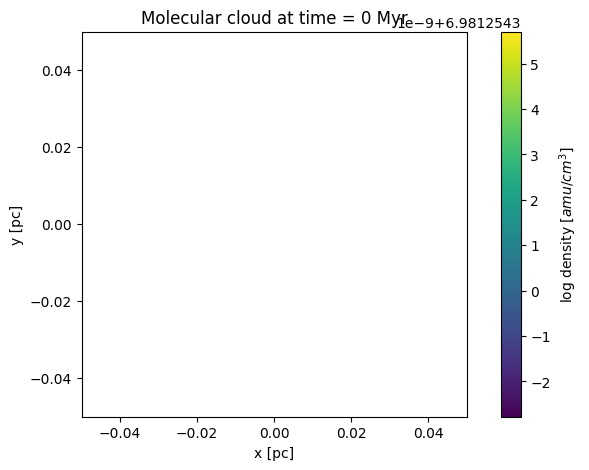

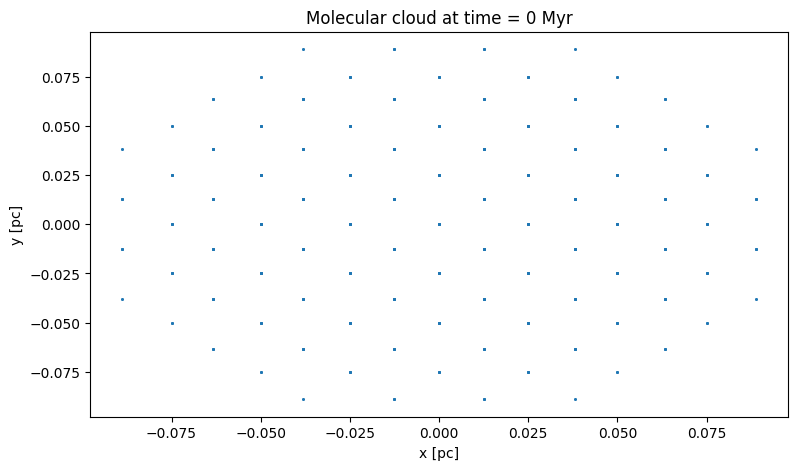

ready for evolution


CodeException: Exception when calling function 'evolve_model', of code 'FiInterface', exception was 'lost connection to code'

In [5]:
particles_cloud, converter_cloud  = make_molecular_cloud(N_cloud = 500,
                                                         M_cloud = 1_000 | units.MSun,
                                                         R_cloud = 0.1 | units.parsec,
                                                         seed = 1312)

print(f"Average mass of a SPH particle {particles_cloud.mass.sum().value_in(units.MSun)/len(particles_cloud.mass)}.")

particles_cloud = evolve_molecular_cloud(particles_cloud, 
                                         converter_cloud, 
                                         2 | units.Myr, 
                                         0.2 | units.Myr, 
                                         1 | units.RSun,
                                         1312)

print(f"Average mass of a SPH particle {particles_cloud.mass.sum().value_in(units.MSun)/len(particles_cloud.mass)}.")
print(f"Average radius of a SPH particle {particles_cloud.radius.sum().value_in(units.RSun)/len(particles_cloud.mass)}.")

# particles_cloud, converter_cloud = make_molecular_cloud(100_000, 10_000_000 | units.MSun, 200 | units.parsec, 1312)
# particles_cloud = evolve_molecular_cloud(particles_cloud, converter_cloud, 2 | units.Myr, 0.2 | units.Myr, 1 | units.RSun, 1312)

In [ ]:
dir(particles_cloud)

: 

Restarted Python 3.8.10

In [1]:
from amuse.lab import nbody_system

from amuse.ext.molecular_cloud import molecular_cloud
from amuse.ext.evrard_test import body_centered_grid_unit_cube

from amuse.community.fi.interface import Fi

from amuse.units import units
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# plot molecular cloud density function (smooth)
def make_map(hydro, L, N):
    '''
    Description:

    Inputs:
        hydro (object): AMUSE Fi hydrodynamic integrator
        L (int): Axis length 
        N (int): Number of grid points

    Return: 
        rho ()
    '''

    x = np.linspace(-L, L, N + 1)
    y = np.linspace(-L, L, N + 1)
    xv, yv = np.meshgrid(x, y)

    x = xv.flatten() | units.pc
    y = yv.flatten() | units.pc
    z = 0 | units.pc
    vx = 0 | units.kms
    vy = 0 | units.kms
    vz = 0 | units.kms

    rho = hydro.get_hydro_state_at_point(x, y, z, vx, vy, vz)[0]
    rho = rho.reshape((N + 1, N + 1))
    
    return rho
    
def plot_hydro(time, hydro, L, N):

    fig = plt.figure(figsize = (9, 5))
    
    rho = make_map(hydro, L = L, N = N)
    cax = plt.imshow(np.log10(rho.value_in(units.amu/units.cm**3)), extent=[-L, L, -L, L]) #, vmin = 0, vmax = 5)
    cbar = fig.colorbar(cax)
    cbar.set_label('log density [$amu/cm^3$]', labelpad = 5)
        
    plt.title("Molecular cloud at time = " + time.as_string_in(units.Myr))
    plt.xlabel("x [pc]")
    plt.ylabel("y [pc]")
    plt.show()

def plot_cloud_particles(time, particles_cloud):

    fig = plt.figure(figsize = (9, 5))

    plt.scatter(particles_cloud.x.value_in(units.pc), particles_cloud.y.value_in(units.pc), s = 1)
    plt.title("Molecular cloud at time = " + time.as_string_in(units.Myr))
    plt.xlabel("x [pc]")
    plt.ylabel("y [pc]")
    plt.show()

In [3]:
def make_molecular_cloud(N_cloud, M_cloud, R_cloud, seed):
    '''
    Description:
        Generating a molecular cloud
        
    Inputs:
        N_cloud (Int): Number of particles in the molecular cloud
        
        M_cloud (units.quantity): Total mass of the cloud
        
        R_cloud (units.quantity): Radius of the cloud
        
        seed (int): Randomness of the function
    
    Returns:
        particles_cloud (object): AMUSE particle set for the molecular cloud
        converter_cloud (object): AMUSE generic unit converter for the cloud 
    '''

    converter_cloud = nbody_system.nbody_to_si(M_cloud, R_cloud)

    # creates a smooth spherical cloud with random velocities as in Bonnell et al. (2003)
    particles_cloud = molecular_cloud(targetN = N_cloud, 
                                    convert_nbody = converter_cloud,
                                    base_grid = body_centered_grid_unit_cube,
                                    seed = seed).result 
    
    return particles_cloud, converter_cloud

In [4]:
def evolve_molecular_cloud(particles_cloud, converter_cloud, t_end, dt, resolution, seed):
    '''
    Description:
        Evolve a existing molecular cloud to a certain age

    Inputs:
        particles_cloud (object): AMUSE particle set for the molecular cloud 
        converter_cloud (object): AMUSE generic unit converter
        t_end (units.quantity): Total length of the evolution
        dt (units.quantity): Time step of the evolution
        resolution (units.quantity): Gas particle smoothing length 
        seed (int): Randomness of the function 

    Return:
        particles_cloud (object): AMUSE particle set for the evolved molecular cloud

    '''

    np.random.seed(seed)

    hydro_cloud = Fi(converter_cloud)

    hydro_cloud.parameters.use_hydro_flag = True # Hydrodynamics flag. True means: SPH hydro included, False means: gravity only.
    hydro_cloud.parameters.radiation_flag = False # Radiation flag. True means: radiation (i.e. radiative cooling/heating) is included. False means: no radiation, and implies no star formation. (default value:False)

    hydro_cloud.parameters.gamma = 1 # gas polytropic index (1.6666667) (default value:1.6666667)
    hydro_cloud.parameters.isothermal_flag = True # Isothermal flag. True means: isothermal gas (requires integrate_entropy_flag == False). (default value:False)
    hydro_cloud.parameters.integrate_entropy_flag = False # Integrate-entropy flag. True means: integrate entropy, else: internal energy. (default value:True)
    hydro_cloud.parameters.timestep = dt # timestep for system (default value:4.70451599238e+13 s)

    hydro_cloud.parameters.eps_is_h_flag = False  #Eps-is-h flag. True means: set gas particles gravitational epsilon to h (SPH smoothing length). (default value:True)
                                                # h_smooth is constant
    hydro_cloud.parameters.gas_epsilon = resolution # The gas gravitational smoothing epsilon.
    hydro_cloud.parameters.sph_h_const = resolution # SPH smoothing length if constant
    particles_cloud.h_smooth= resolution

    hydro_cloud.gas_particles.add_particles(particles_cloud)

    channel = {"hydro_to_part": hydro_cloud.gas_particles.new_channel_to(particles_cloud),
            "part_to_hydro": particles_cloud.new_channel_to(hydro_cloud.gas_particles)}

    L = int(max(particles_cloud.x.value_in(units.pc)))*1.5  # x and y lim of plot. 
    N = 1000 # amount of grid points

    model_time = 0 | units.Myr

    plot_hydro(model_time, hydro_cloud, L, N)
    plot_cloud_particles(model_time, particles_cloud)
    print("ready for evolution")

    while model_time < t_end:

        model_time += dt
        model_time = model_time.round(1)

        hydro_cloud.evolve_model(model_time)
        print("Time", model_time.in_(units.Myr))
        channel["hydro_to_part"].copy()

    plot_hydro(model_time, hydro_cloud, L, N)
    plot_hydro(model_time, hydro_cloud, 25, N)
    plot_cloud_particles(model_time, particles_cloud)

    hydro_cloud.stop()

    return particles_cloud

Average mass of a SPH particle 1.8832391713747643.


<ipython-input-2-c60224121ede>:38: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  cax = plt.imshow(np.log10(rho.value_in(units.amu/units.cm**3)), extent=[-L, L, -L, L]) #, vmin = 0, vmax = 5)
<ipython-input-2-c60224121ede>:38: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  cax = plt.imshow(np.log10(rho.value_in(units.amu/units.cm**3)), extent=[-L, L, -L, L]) #, vmin = 0, vmax = 5)


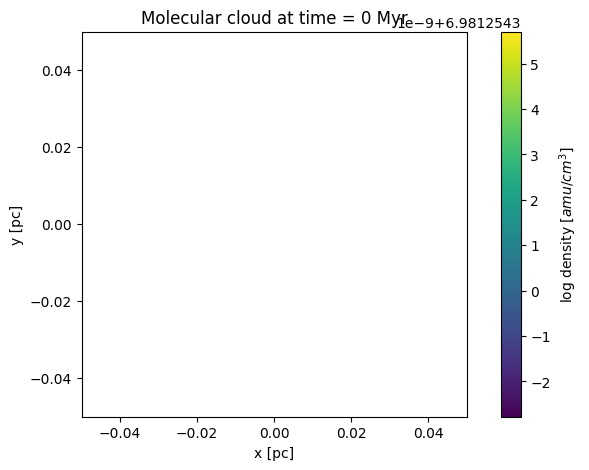

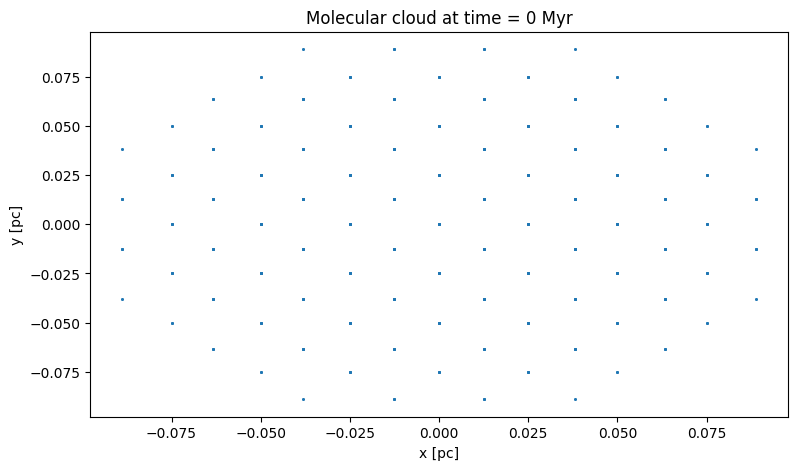

ready for evolution


CodeException: Exception when calling function 'evolve_model', of code 'FiInterface', exception was 'lost connection to code'

In [5]:
particles_cloud, converter_cloud  = make_molecular_cloud(N_cloud = 500,
                                                         M_cloud = 1_000 | units.MSun,
                                                         R_cloud = 0.1 | units.parsec,
                                                         seed = 1312)

print(f"Average mass of a SPH particle {particles_cloud.mass.sum().value_in(units.MSun)/len(particles_cloud.mass)}.")

particles_cloud = evolve_molecular_cloud(particles_cloud, 
                                         converter_cloud, 
                                         2 | units.Myr, 
                                         0.2 | units.Myr, 
                                         1 | units.RSun,
                                         1312)

print(f"Average mass of a SPH particle {particles_cloud.mass.sum().value_in(units.MSun)/len(particles_cloud.mass)}.")
print(f"Average radius of a SPH particle {particles_cloud.radius.sum().value_in(units.RSun)/len(particles_cloud.mass)}.")

# particles_cloud, converter_cloud = make_molecular_cloud(100_000, 10_000_000 | units.MSun, 200 | units.parsec, 1312)
# particles_cloud = evolve_molecular_cloud(particles_cloud, converter_cloud, 2 | units.Myr, 0.2 | units.Myr, 1 | units.RSun, 1312)